<a href="https://colab.research.google.com/github/roy2392/ADVENTUREWORKS_SQL/blob/main/Bank_Probability_of_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probability of Default Prediction - CrossRiver Bank

## Introduction

This notebook demonstrates the process of building a logistic regression model to predict the probability of default for a credit scoring task at CrossRiver Bank. We'll go through the following steps:

1. Data Loading and Exploration
2. Feature Engineering
3. Model Building
4. Model Evaluation
5. Feature Importance Analysis
6. Hyperparameter Tuning
7. Final Model Evaluation and Interpretation

Let's start by importing the necessary libraries and loading our data.


## Import Dependencies

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.inspection import PartialDependenceDisplay
import missingno as msno

%matplotlib inline
plt.style.use('seaborn')

<ipython-input-25-e3318386ce01>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [26]:
# Load the data
df = pd.read_csv('bank.csv')

## 1. Exploratory Data Analysis (EDA)

Let's start by examining our dataset.

In [27]:
df.head()

,loan_applicant_id,age,education,years_with_current_employer,years_at_current_address,household_income,debt_to_income_ratio,credit_card_debt,other_debt,y
0,191,44,university.degree,10,20,192,12.116645,14.377313,8.886645,1
1,34318,34,high.school,3,18,57,14.264229,5.137880,2.992730,0
2,14932,45,university.degree,14,24,212,7.285681,10.460306,4.985339,0
3,2776,33,illiterate,12,5,418,11.386272,3.040189,44.554429,1
4,11915,20,basic,4,19,122,28.418494,14.560450,20.110112,0


In [28]:
# Basic information
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   loan_applicant_id            41188 non-null  int64  
 1   age                          41188 non-null  int64  
 2   education                    41188 non-null  object 
 3   years_with_current_employer  41188 non-null  int64  
 4   years_at_current_address     41188 non-null  int64  
 5   household_income             41188 non-null  int64  
 6   debt_to_income_ratio         41188 non-null  float64
 7   credit_card_debt             41188 non-null  float64
 8   other_debt                   41188 non-null  float64
 9   y                            41188 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 3.1+ MB
None
       loan_applicant_id           age  years_with_current_employer  \
count        41188.00000  41188.000000                 41

what this information tell us:
* no missing values (41,188 non-null values) </br>
* 1 categorial feature - education >/br>
* Age: The average age is about 38 years, with a range from 20 to 56 years. </br>
* Credit Card Debt: Highly variable, with a mean of 9.58 and a maximum of 149.02. </br>
* The debt values (credit card and other) have very wide ranges, which might need to be addressed in preprocessing (e.g., log transformation).

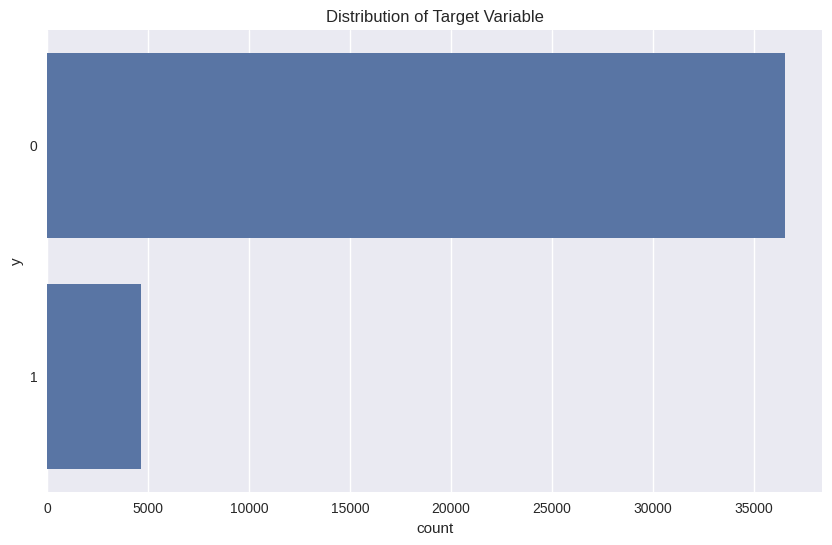

y
0    0.887346
1    0.112654
Name: proportion, dtype: float64


In [29]:
# Target variable distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='y', data=df)
plt.title('Distribution of Target Variable')
plt.show()

print(df['y'].value_counts(normalize=True))

11% of the customers failed to repay their loan.

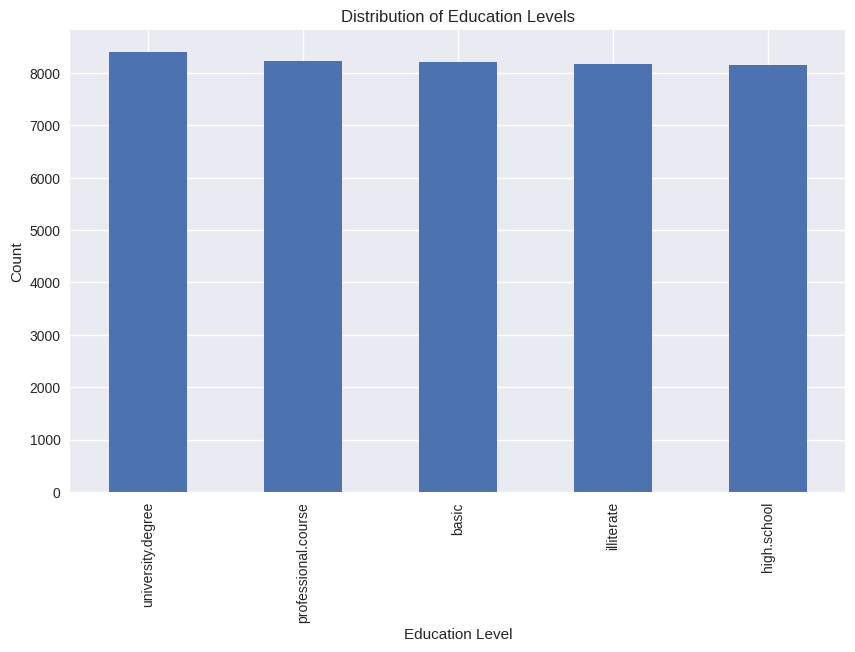

In [30]:
# Education distribution
plt.figure(figsize=(10, 6))
df['education'].value_counts().plot(kind='bar')
plt.title('Distribution of Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.show()

the distribution of customers across different types of eduction types is similar

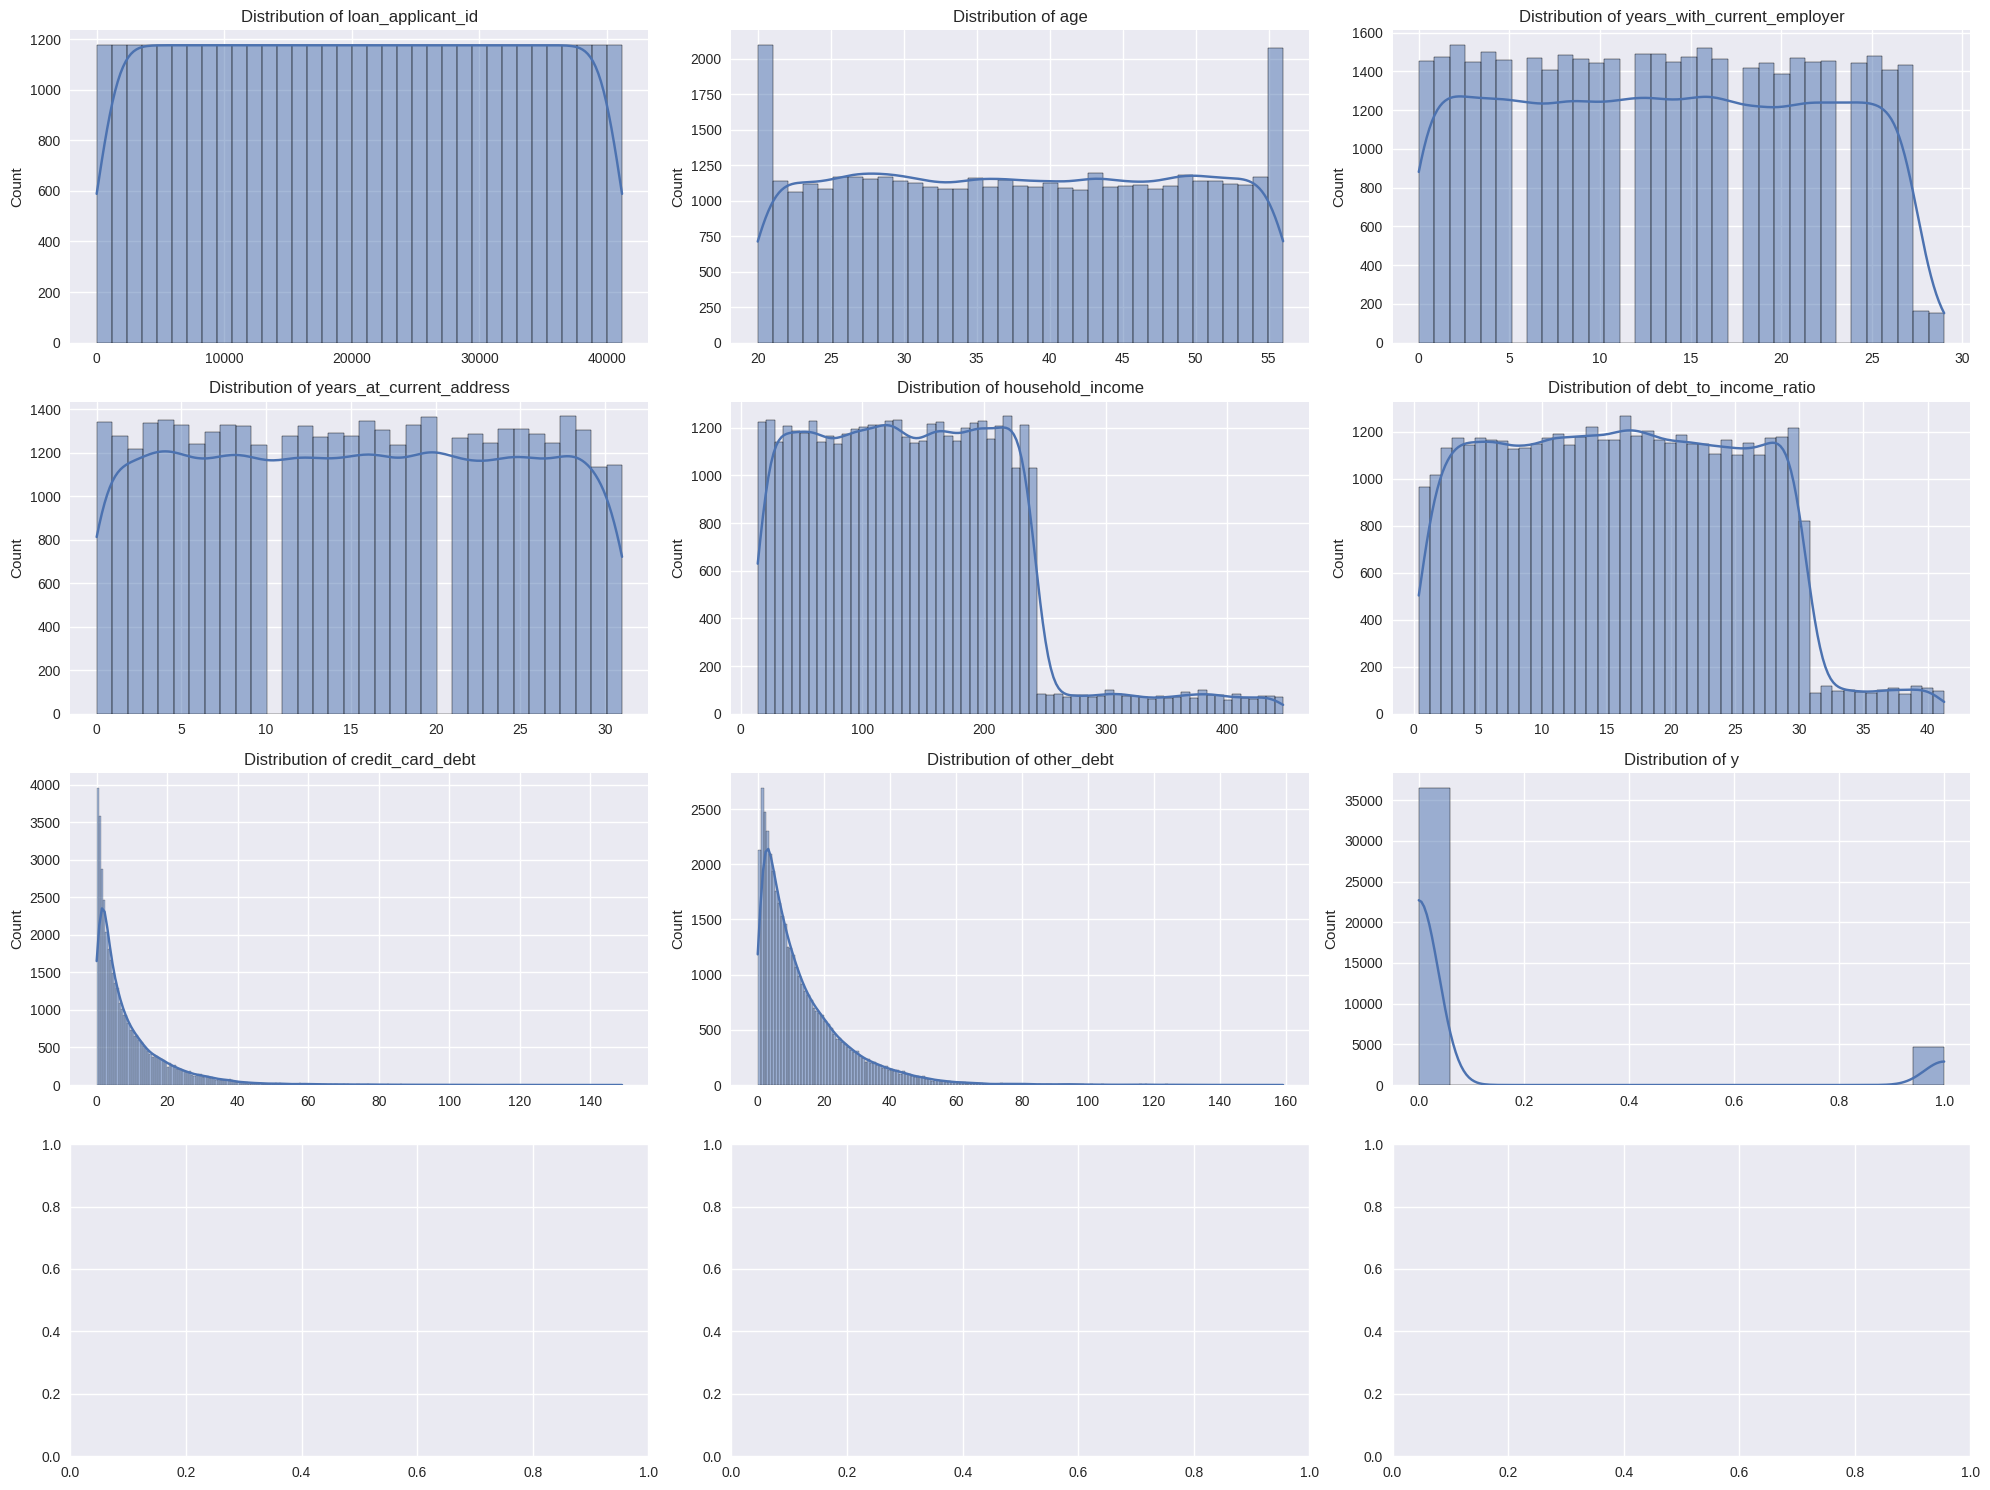

In [31]:
# Numerical variables distribution
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

fig, axes = plt.subplots(nrows=len(num_cols)//3 + 1, ncols=3, figsize=(20, 5*len(num_cols)//3))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

* age: Roughly normal distribution, with a peak on ages 20 & 55 years </br>
* household_income: Mostly uniform distribution up to about 250k, then a sharp decline for higher incomes. </br>
* years_with_current_employer: Fairly uniform distribution up to about 25 years, then a sharp decline for longer tenures.

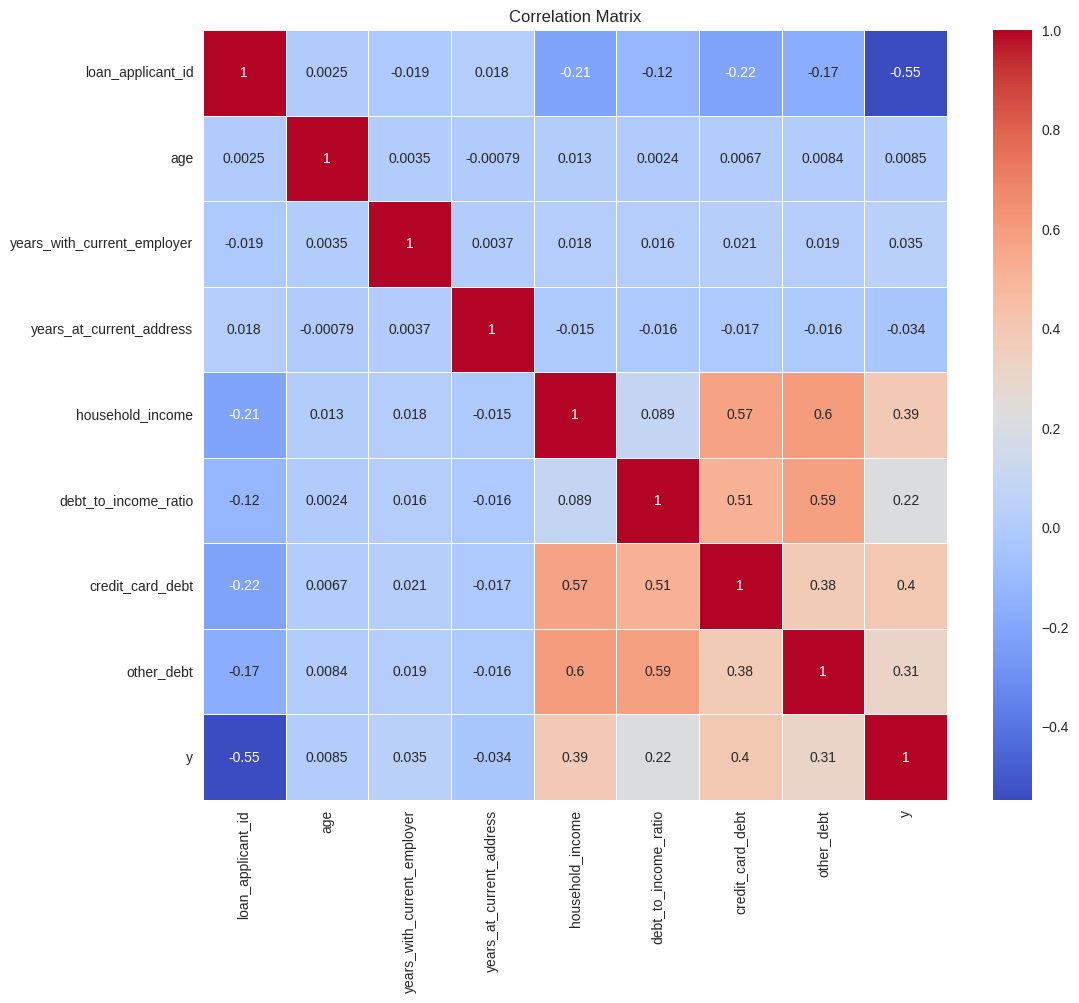

In [32]:
# Correlation analysis
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<ul>
  <li><strong>Moderate positive correlations:</strong>
    <ul>
      <li>'household_income' with 'credit_card_debt' (0.57) and 'other_debt' (0.6)</li>
      <li>'debt_to_income_ratio' with 'credit_card_debt' (0.51) and 'other_debt' (0.59)</li>
    </ul>

## 2. Data Preprocessing & Feature Engineering


Now that we've explored our data, let's preprocess it and engineer some new features.


In [33]:
# Imputation (if needed)
if df.isnull().sum().sum() > 0:
    # For numerical columns, impute with median
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)

    # For categorical columns, impute with mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)

    print("\nMissing values after imputation:")
    print(df.isnull().sum())

In [34]:
# # Handling outliers
# def remove_outliers(df, col):
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# for col in num_cols:
#     df = remove_outliers(df, col)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   loan_applicant_id            41188 non-null  int64  
 1   age                          41188 non-null  int64  
 2   education                    41188 non-null  object 
 3   years_with_current_employer  41188 non-null  int64  
 4   years_at_current_address     41188 non-null  int64  
 5   household_income             41188 non-null  int64  
 6   debt_to_income_ratio         41188 non-null  float64
 7   credit_card_debt             41188 non-null  float64
 8   other_debt                   41188 non-null  float64
 9   y                            41188 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 3.1+ MB


In [36]:

def engineer_features(df):
    # Age categories
    df['age_category'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, np.inf], labels=['18-25', '26-35', '36-45', '46-55', '56+'])

    # # Education level encoding
    # education_mapping = {
    #     'illiterate': 0,
    #     'basic': 1,
    #     'high.school': 2,
    #     'professional.course': 3,
    #     'university.degree': 4
    # }
    # df['education_level'] = df['education'].map(education_mapping)

    # # One-hot encoding for education
    # df = pd.get_dummies(df, columns=['education'], prefix='edu')

    # Employment stability
    df['employment_stability'] = df['years_with_current_employer'] / df['age']

    # Address stability
    df['address_stability'] = df['years_at_current_address'] / df['age']

    # Total debt
    df['total_debt'] = df['credit_card_debt'] + df['other_debt']

    # Debt ratio
    df['debt_ratio'] = df['total_debt'] / df['household_income']

    # Credit card to total debt ratio
    df['credit_card_debt_ratio'] = df['credit_card_debt'] / df['total_debt']

    # Income to age ratio
    df['income_age_ratio'] = df['household_income'] / df['age']

    # Debt-free years
    df['potential_debt_free_years'] = (df['age'] - 18) - df['years_with_current_employer']

    # Income category
    df['income_category'] = pd.qcut(df['household_income'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

    return df

# Assuming your dataframe is called 'loan_df'
df = engineer_features(df)

In [37]:
# Define features and target
X = df.drop('y', axis=1)
y = df['y']

In [38]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Model Building with Pipeline

In [39]:
df.head()

,loan_applicant_id,age,education,years_with_current_employer,years_at_current_address,household_income,debt_to_income_ratio,credit_card_debt,other_debt,y,age_category,employment_stability,address_stability,total_debt,debt_ratio,credit_card_debt_ratio,income_age_ratio,potential_debt_free_years,income_category
0,191,44,university.degree,10,20,192,12.116645,14.377313,8.886645,1,36-45,0.227273,0.454545,23.263958,0.121166,0.618008,4.363636,16,High
1,34318,34,high.school,3,18,57,14.264229,5.137880,2.992730,0,26-35,0.088235,0.529412,8.130610,0.142642,0.631918,1.676471,13,Very Low
2,14932,45,university.degree,14,24,212,7.285681,10.460306,4.985339,0,36-45,0.311111,0.533333,15.445644,0.072857,0.677233,4.711111,13,Very High
3,2776,33,illiterate,12,5,418,11.386272,3.040189,44.554429,1,26-35,0.363636,0.151515,47.594618,0.113863,0.063877,12.666667,3,Very High
4,11915,20,basic,4,19,122,28.418494,14.560450,20.110112,0,18-25,0.200000,0.950000,34.670562,0.284185,0.419966,6.100000,-2,Medium


In [40]:
# Define preprocessing for numeric columns (scale them)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [41]:
# Define preprocessing for categorical columns (encode them)
categorical_features = ['education']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [43]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=42))])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['loan_applicant_id', 'age', 'years_with_current_employer',
       'years_at_current_address', 'household_income', 'debt_to_income_ratio',
       'credit_card_debt', 'other_debt', 'employment_stability',
       'address_stability', 'total_debt', 'debt_ratio',
       'credit_card_debt_ratio', 'income_age_ratio',
       'potential_debt_free_years'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['education'])])),
                ('classifier', LogisticRegression(random_state=42))])

## 4. Model Evaluation

Let's evaluate our model's performance.


In [44]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7310
           1       0.98      0.98      0.98       928

    accuracy                           1.00      8238
   macro avg       0.99      0.99      0.99      8238
weighted avg       1.00      1.00      1.00      8238



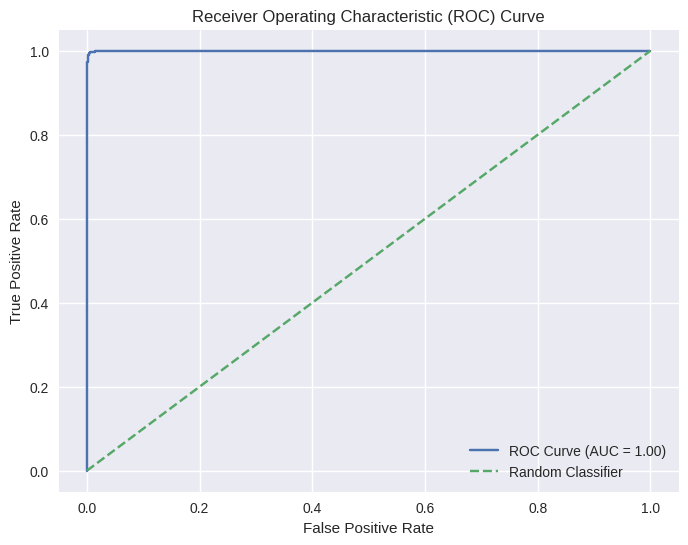

In [45]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_roc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

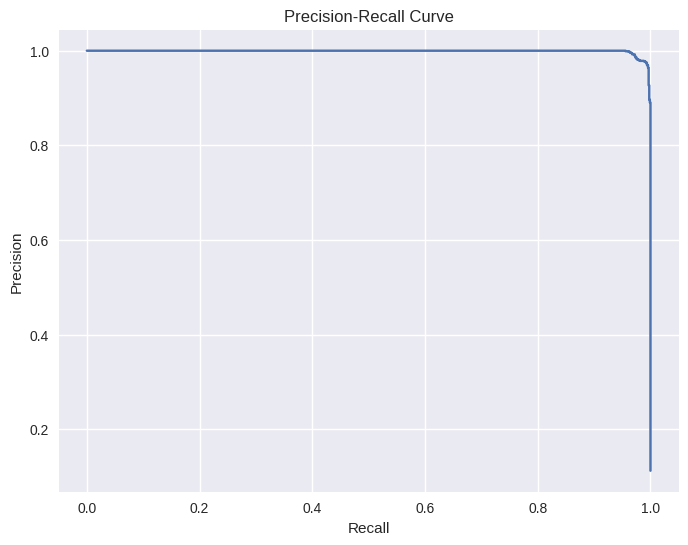

In [46]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

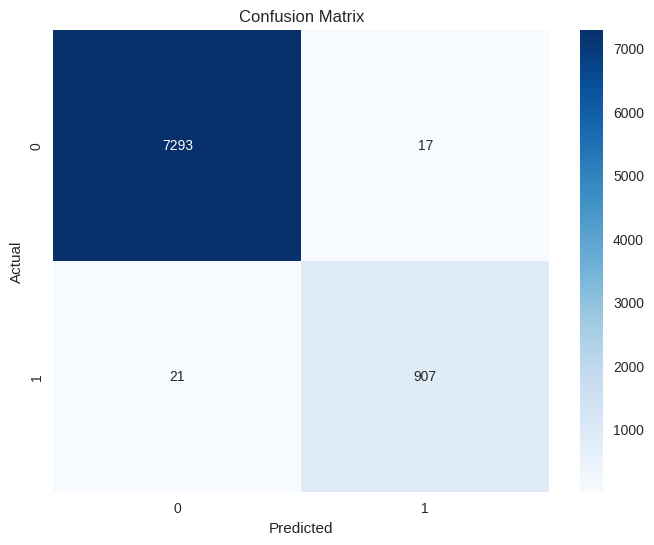

In [47]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 5. Feature Importance


Let's analyze which features are most important for our model.


In [48]:
feature_names = (clf.named_steps['preprocessor']
                 .named_transformers_['num']
                 .get_feature_names(numeric_features).tolist() +
                 clf.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names(categorical_features).tolist())

coefficients = clf.named_steps['classifier'].coef_[0]

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(coefficients)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

AttributeError: 'Pipeline' object has no attribute 'get_feature_names'